<a href="https://colab.research.google.com/github/neuralnetworksrs/Tarea-2/blob/master/Parte_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Aplicaciones Recientes de Redes Neuronales </H3>
<hr style="height:2px;border:none"/>

**Temas**  

* Diseño e implementación detallado de Redes Recurrentes (RNN) y sus derivados.
* Compuertas LSTM y GRU. 
* Arquitectura Encoder-Decoder para problemas de *traducción*.
* Arquitectura de Autoencoder para reducción de dimensionalidad.
* Modelos generativos profundos: VAEs (*Variational Autoencoder*)

** Formalidades **  
* Equipos de trabajo de: 2-3 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: por definir.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea2-INF395-I-2019]

<hr style="height:2px;border:none"/>
La tarea se divide en secciones:

[0+.](#bonus) Bonus  
[1.](#primero) RNN sobre texto  
[2.](#segundo) *Encoder-Decoder* sobre imágenes    
[3.](#tercero) *Encoder-Decoder* sobre Texto    
[4.](#cuarto) Distintos tipos de autoencoders (AEs) en MNIST    

<a id="tercero"></a>
## 3. *Encoder-Decoder* sobre Texto

Trabajos recientes en redes neuronales han demostrado que se puede aplicar a problemas bastante complejos gracias a la flexibilidad la definición de las redes, además de que se pueden adaptar a distintos tipos de datos brutos (dominios). Con el objetivo de explorar el enfoque anterior de *traducción* de algun tipo de dato, en esta sección deberá realizarlo con texto para traducción de un lenguaje humano a otro (e.g. inglés a alemán, chino a ruso).

<img src="https://www.panoramaila.cz/images/preklady.jpg" width="35%" />


Trabajaremos con el dataset de pares de sentencias bilingues entre distintos idiomas del proyecto __[Tatoeba](http://www.manythings.org/anki/)__. El objetivo entonces consta de tomar un texto en lenguaje natural de algún idioma (*source*) y traducirlo a otro texto en lenguaje natural de otro idioma (*target*), donde cada texto tendrá un largo variable. Lo cual se empleará a través de extrar información del texto *source* (*encoder*) para luego generar el texto *target* (*decoder*) en base a esta información extraída.


Deberá seleccionar el *dataset* que guste para trabajar con la tarea de traducción, comente sobre su decisión. Luego cárgelo con *pandas*.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


 a) Visualice los datos ¿Qué es la entrada y qué es la salida? Comente sobre los múltiples significados/sinónimos que puede tener una palabra al ser traducida y cómo propondría arreglar eso. *se espera que pueda implementarlo*

In [0]:
import pandas as pd
import numpy as np
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/jpn.txt", sep="\t", names=["Source","Target"])
df.head()

Source  Target
0    Go.     行け。
1    Go.  行きなさい。
2    Hi.  こんにちは。
3    Hi.   やっほー。
4    Hi.  こんにちは！

In [0]:
df.tail()

Source                                             Target
45088  Tom said, "You can kiss your girlfriend goodby...  「恋人にさよならのキスくらいしないと、キスしてあばよ、ということになるぞ」とトムは言ったが、...
45089  Five tremors in excess of magnitude 5.0 on the...  日本ではリヒター・スケールでマグニチュード5.0以上の余震が今週5回ありました。しかし科学者...
45090  The bus now arriving is going to Domestic Term...  ただ今到着のバスは、国内線第1ターミナル行きです。国際線ターミナルにお越しの方は、しばらくそ...
45091  A child who is a native speaker usually knows ...  ネイティブの子どもは、何年も学んだ非ネイティブが知らず今後も知り得ないたくさんのことを自身の...
45092  I do many things at the same time, so not only...  色々並行してやってるから芥川ばかり読んでるのでもないのだよ。今は英語読んでる時間が増えてる。...

La entrada del dataset corresponde a palabras o frases que están escritas en inglés, por consecuencia, el output tiene que ser la palabra o frase traducida al japonés.

Se puede ver en el $head$ del dataset que hay palabras que se escriben de la misma forma en inglés pero tienen un traducción completamente distinta en japonés. Lo anterior se debe a que el idioma del inglés no posee una conjugación explícita por palabra, sino que se adecua según el contexto en la cual se esté usando, por este motivo, la red al entrenar los datos debería tener cierto problemas. Para evitar esto, se unifican los sínónimos de dicha palabra y se crea un array de sinónimos por cada palabra $Target$.

In [0]:
fixed = {}
for i in range(0,len(df['Source'])):
  if df['Source'][i] in fixed:
    fixed[df['Source'][i]].append(df['Target'][i])
  else:
    fixed[df['Source'][i]] = [df['Target'][i]]

fixed

source = list(fixed.keys())
target = list(fixed.values())

In [0]:
new_df = pd.DataFrame({'Source': source, 'Target': target})
new_df.head()

Source                   Target
0    Go.            [行け。, 行きなさい。]
1    Hi.  [こんにちは。, やっほー。, こんにちは！]
2   Run.              [走れ。, 走って！]
3   Who?                     [誰？]
4   Wow!         [すごい！, ワォ！, わぉ！]

In [0]:
new_df.tail()

Source                                             Target
38603  Tom said, "You can kiss your girlfriend goodby...  [「恋人にさよならのキスくらいしないと、キスしてあばよ、ということになるぞ」とトムは言ったが...
38604  Five tremors in excess of magnitude 5.0 on the...  [日本ではリヒター・スケールでマグニチュード5.0以上の余震が今週5回ありました。しかし科学...
38605  The bus now arriving is going to Domestic Term...  [ただ今到着のバスは、国内線第1ターミナル行きです。国際線ターミナルにお越しの方は、しばらく...
38606  A child who is a native speaker usually knows ...  [ネイティブの子どもは、何年も学んだ非ネイティブが知らず今後も知り得ないたくさんのことを自身...
38607  I do many things at the same time, so not only...  [色々並行してやってるから芥川ばかり読んでるのでもないのだよ。今は英語読んでる時間が増えてる...

b) Realice un pre-procesamiento a los textos como se acostumbra para eliminar símbolos inecesarios u otras cosas que estime conveniente, comente sobre la importancia de éste paso. Además de ésto deberá agregar un símbolo al final de la sentencia *target* para indicar un "alto" cuando la red neuronal necesite aprender a generar una sentencia.


In [0]:
import string
table = str.maketrans('', '', string.punctuation) 
def clean_text(text, where=None):
    """ OJO: Sin eliminar el significado de las palabras."""
    if type(text) is list:
      text = text[0].lower()
    else:
      text = text.lower()
    tokenize_text = text.split()
    if where != "target":
      tokenize_text = [word.translate(table) for word in tokenize_text]#eliminar puntuacion
      tokenize_text = [word for word in tokenize_text if word.isalpha()] #remove numbers
    else:
        tokenize_text = tokenize_text + ["#end"] 
    return tokenize_text
texts_input = list(df['Source'].apply(clean_text))
texts_output = list(df['Target'].apply(clean_text, where='target'))
new_texts_input = list(new_df['Source'].apply(clean_text))
new_texts_output = list(new_df['Target'].apply(clean_text, where='target'))

In [0]:
print(texts_input)

[['go'], ['go'], ['hi'], ['hi'], ['hi'], ['run'], ['run'], ['who'], ['wow'], ['wow'], ['wow'], ['fire'], ['fire'], ['fire'], ['help'], ['jump'], ['jump'], ['jump'], ['jump'], ['jump'], ['jump'], ['jump'], ['jump'], ['stop'], ['stop'], ['wait'], ['go', 'on'], ['go', 'on'], ['go', 'on'], ['go', 'on'], ['hello'], ['hello'], ['hello'], ['hurry'], ['i', 'see'], ['i', 'see'], ['i', 'see'], ['i', 'see'], ['i', 'see'], ['i', 'see'], ['i', 'see'], ['i', 'try'], ['i', 'try'], ['i', 'try'], ['i', 'try'], ['i', 'try'], ['i', 'won'], ['i', 'won'], ['i', 'won'], ['i', 'won'], ['i', 'won'], ['oh', 'no'], ['oh', 'no'], ['oh', 'no'], ['oh', 'no'], ['oh', 'no'], ['oh', 'no'], ['relax'], ['relax'], ['relax'], ['relax'], ['shoot'], ['smile'], ['smile'], ['cheers'], ['freeze'], ['get', 'up'], ['get', 'up'], ['get', 'up'], ['go', 'now'], ['got', 'it'], ['got', 'it'], ['he', 'ran'], ['he', 'ran'], ['hop', 'in'], ['hop', 'in'], ['hug', 'me'], ['hug', 'me'], ['i', 'know'], ['i', 'know'], ['i', 'left'], ['i', '

In [0]:
print(new_texts_input)

[['go'], ['hi'], ['run'], ['who'], ['wow'], ['fire'], ['help'], ['jump'], ['jump'], ['stop'], ['wait'], ['go', 'on'], ['hello'], ['hurry'], ['i', 'see'], ['i', 'try'], ['i', 'won'], ['oh', 'no'], ['relax'], ['shoot'], ['smile'], ['cheers'], ['freeze'], ['get', 'up'], ['go', 'now'], ['got', 'it'], ['he', 'ran'], ['hop', 'in'], ['hug', 'me'], ['i', 'know'], ['i', 'left'], ['i', 'lost'], ['i', 'quit'], ['im'], ['im', 'ok'], ['im', 'up'], ['listen'], ['no', 'way'], ['really'], ['thanks'], ['we', 'try'], ['we', 'won'], ['why', 'me'], ['ask', 'tom'], ['awesome'], ['be', 'calm'], ['be', 'cool'], ['be', 'fair'], ['be', 'kind'], ['be', 'nice'], ['beat', 'it'], ['call', 'me'], ['call', 'us'], ['come', 'in'], ['come', 'on'], ['get', 'tom'], ['get', 'out'], ['get', 'out'], ['go', 'away'], ['go', 'away'], ['go', 'home'], ['go', 'slow'], ['goodbye'], ['hang', 'on'], ['hang', 'on'], ['he', 'came'], ['he', 'quit'], ['he', 'runs'], ['help', 'me'], ['help', 'me'], ['help', 'us'], ['hi', 'tom'], ['hit', 

In [0]:
print(texts_output)

[['行け。', '#end'], ['行きなさい。', '#end'], ['こんにちは。', '#end'], ['やっほー。', '#end'], ['こんにちは！', '#end'], ['走れ。', '#end'], ['走って！', '#end'], ['誰？', '#end'], ['すごい！', '#end'], ['ワォ！', '#end'], ['わぉ！', '#end'], ['火事だ！', '#end'], ['火事！', '#end'], ['撃て！', '#end'], ['助けて！', '#end'], ['飛び越えろ！', '#end'], ['跳べ！', '#end'], ['飛び降りろ！', '#end'], ['飛び跳ねて！', '#end'], ['ジャンプして！', '#end'], ['跳べ！', '#end'], ['飛び跳ねて！', '#end'], ['ジャンプして！', '#end'], ['やめろ！', '#end'], ['止まれ！', '#end'], ['待って！', '#end'], ['続けて。', '#end'], ['進んで。', '#end'], ['進め。', '#end'], ['続けろ。', '#end'], ['こんにちは。', '#end'], ['もしもし。', '#end'], ['こんにちは！', '#end'], ['急げ！', '#end'], ['なるほど。', '#end'], ['なるほどね。', '#end'], ['わかった。', '#end'], ['わかりました。', '#end'], ['そうですか。', '#end'], ['そうなんだ。', '#end'], ['そっか。', '#end'], ['頑張ってみる。', '#end'], ['やってみる。', '#end'], ['試してみる。', '#end'], ['やってみよう！', '#end'], ['トライしてみる。', '#end'], ['俺の勝ちー！', '#end'], ['勝ったぁ！', '#end'], ['勝ったぞ！', '#end'], ['私の勝ち！', '#end'], ['私が勝ち！', '#end'], ['なんてこった！', '#end'], ['なんてことだ！', '#e

In [0]:
print(new_texts_output)

[['行け。', '#end'], ['こんにちは。', '#end'], ['走れ。', '#end'], ['誰？', '#end'], ['すごい！', '#end'], ['火事だ！', '#end'], ['助けて！', '#end'], ['飛び越えろ！', '#end'], ['跳べ！', '#end'], ['やめろ！', '#end'], ['待って！', '#end'], ['続けて。', '#end'], ['こんにちは。', '#end'], ['急げ！', '#end'], ['なるほど。', '#end'], ['頑張ってみる。', '#end'], ['俺の勝ちー！', '#end'], ['なんてこった！', '#end'], ['落ち着いて。', '#end'], ['撃て！', '#end'], ['はい、チーズ。', '#end'], ['乾杯！', '#end'], ['動くな！', '#end'], ['起きなさい！', '#end'], ['さあ、行っといで。', '#end'], ['捕まえた。', '#end'], ['彼は走った。', '#end'], ['乗れよ。', '#end'], ['抱きしめて。', '#end'], ['分かってる。', '#end'], ['出発した', '#end'], ['負けた・・・。', '#end'], ['私、辞めます。', '#end'], ['１９歳です。', '#end'], ['大丈夫ですよ。', '#end'], ['起きてるよ。', '#end'], ['聞きなさい。', '#end'], ['馬鹿な！', '#end'], ['本当？', '#end'], ['ありがとうございます！', '#end'], ['私たちは努力しております。', '#end'], ['俺らの勝ちー！', '#end'], ['何でわたしなの？', '#end'], ['トムに聞きなさい。', '#end'], ['すごいぞ！', '#end'], ['落ち着いて。', '#end'], ['落ち着いて。', '#end'], ['フェアに行こうぜ。', '#end'], ['譲り合いましょう。', '#end'], ['お行儀よくしなさい。', '#end'], ['どっか行け。',

Cree un conjunto de validación y de pruebas fijos de $N_{exp} = 10000$ datos ¿Cuántos datos quedan para entrenar? 

In [0]:
from sklearn.model_selection import train_test_split
N_exp = 10000
X_train_l, X_test_l, Y_train_l, Y_test_l = train_test_split(texts_input, texts_output,
                                                            test_size=N_exp, random_state=22)
X_train_l, X_val_l, Y_train_l, Y_val_l = train_test_split(X_train_l, Y_train_l, 
                                                          test_size=N_exp, random_state=22)

*Recuerde que si no puede procesar los datos de entrenamiento adecuadamente siempre puede muestrear en base a la capacidad de cómputo que posea*

c) Genere un vocabulario, **desde el conjunto de entrenamiento**, sobre las palabras a recibir y generar en la traducción, esto es codificarlas a un valor entero que servirá para que la red las vea en una representación útil a procesar, *comience desde el 1 debido a que el cero será utilizado más adelante*. Para reducir el vocabulario considere las palabras que aparecen un mínimo de *min_count* veces en todo los datos, se aconseja un valor de 3. Comente sobre la importancia de ésto al reducir el vocabulario ¿De qué tamaño es el vocabulario de entrada y salida? ¿La diferencia de ésto podría ser un factor importante?

In [0]:
def create_vocab(texts, min_count=1):
    count_vocab = {}
    for sentence in texts:
        for word in sentence:
            if word not in count_vocab:
                count_vocab[word] = 1
            else:
                count_vocab[word] += 1
    return [word for word,count in count_vocab.items() if count >= min_count]
vocab_source = create_vocab(X_train_l, min_count=3)
word2idx_s = {w: i+1 for i, w in enumerate(vocab_source)} #index (i+1) start from 1,2,3,...
idx2word_s = {i+1: w for i, w in enumerate(vocab_source)}
n_words_s = len(vocab_source)
vocab_target = create_vocab(Y_train_l, min_count=3)
word2idx_t = {w: i+1 for i, w in enumerate(vocab_target)} #Converting text to numbers
idx2word_t = {i+1: w for i, w in enumerate(vocab_target)} #Converting number to text
n_words_t = len(vocab_target)

In [0]:
print('Tamaño del vocabulario de entrada %d'%n_words_s)
print('Tamaño del vocabulario de salida %d'%n_words_t)

Tamaño del vocabulario de entrada 3330
Tamaño del vocabulario de salida 350


El tamaño de entrada y salida difieren por el tipo de escritura y conjugación propiamente del lenguaje.

El proceso de un encoder es generar un vector de contexto en el cual se encuentran las asociaciones que tienen las palabras dependiendo de como se utilicen, por lo que la diferencia entre el vocabulario de entrada y de salida no afectaría mucho, aunque probablemente no se alcance una tranducción de buena calidad pero sí una aproximación de la misma.


In [0]:
dataX_train = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_train_l]
dataY_train = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_train_l]

In [0]:
dataX_valid = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_val_l]
dataY_valid = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_val_l] 

In [0]:
dataX_test = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_test_l]
dataY_test = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_test_l] 

In [0]:
vocab_source_v = create_vocab(X_val_l, min_count=3)
word2idx_s_v = {w: i+1 for i, w in enumerate(vocab_source_v)} #index (i+1) start from 1,2,3,...
idx2word_s_v = {i+1: w for i, w in enumerate(vocab_source_v)}
n_words_s_v = len(vocab_source_v)
vocab_target_v = create_vocab(Y_val_l, min_count=3)
word2idx_t_v = {w: i+1 for i, w in enumerate(vocab_target_v)} #Converting text to numbers
idx2word_t_v = {i+1: w for i, w in enumerate(vocab_target_v)} #Converting number to text
n_words_t_v = len(vocab_target_v)

In [0]:
vocab_source_tt = create_vocab(X_test_l, min_count=3)
word2idx_s_tt = {w: i+1 for i, w in enumerate(vocab_source_tt)} #index (i+1) start from 1,2,3,...
idx2word_s_tt = {i+1: w for i, w in enumerate(vocab_source_tt)}
n_words_s_tt = len(vocab_source_tt)
vocab_target_tt = create_vocab(Y_test_l, min_count=3)
word2idx_t_tt = {w: i+1 for i, w in enumerate(vocab_target_tt)} #Converting text to numbers
idx2word_t_tt = {i+1: w for i, w in enumerate(vocab_target_tt)} #Converting number to text
n_words_t_tt = len(vocab_target_tt)

Ahora codifique las palabras a los números indexados con el vocabulario. Recuerde que si una palabra en los otros conjuntos, o en el mismo de entrenamiento, no aparece en el vocabulario no se podrá generar una codificación, por lo que será **ignorada** ¿Cómo se podría evitar ésto?

* Disminuyendo la cantidad de palabras por vocabulario
* Ignorar frases que contienen palabras que no están en el vocabulario

d) Debido al largo variable de los textos de entrada y salida será necesario estandarizar ésto para poder trabajar de manera más cómoda en Keras, *cada texto (entrada y salida) pueden tener distinto largo máximo*. Comente sobre la decisión del tipo de *padding*, *pre o post* ¿Qué sucede al variar el largo máximo de instantes de tiempo para procesar en cada parte del modelo (entrada y salida)?

In [0]:
from keras.preprocessing import sequence
""" INPUT DATA (Origin language) """
max_inp_length = max(map(len,dataX_train))
print("Largo max inp: ",max_inp_length)
word2idx_s["*"] = 0 #padding symbol
idx2word_s[0] = "*"
n_words_s += 1  
word2idx_t["*"] = 0 #padding symbol
idx2word_t[0] = "*"
n_words_t += 1 

X_train = sequence.pad_sequences(dataX_train, maxlen=max_inp_length, padding='pre', value=word2idx_s["*"])
X_valid = sequence.pad_sequences(dataX_valid, maxlen=max_inp_length, padding='pre', value=word2idx_s["*"])
X_test = sequence.pad_sequences(dataX_test, maxlen=max_inp_length, padding='pre', value=word2idx_s["*"])
""" OUTPUT DATA (Destination language) """
max_out_length = max(map(len,dataY_train)) 
print("Largo max out: ",max_out_length)
Y_train = sequence.pad_sequences(dataY_train, maxlen=max_out_length, padding='post', value=word2idx_t["*"])
Y_valid = sequence.pad_sequences(dataY_valid, maxlen=max_out_length, padding='post', value=word2idx_t["*"])
Y_test = sequence.pad_sequences(dataY_test, maxlen=max_out_length, padding='post', value=word2idx_t["*"])

Largo max inp:  38
Largo max out:  2


e) Para evitar que la red obtenga una ganancia por imitar/predecir el símbolo de *padding* que está bastante presente en los datos coloque un peso sobre éste clase, con valor 0, así se evita que tenga impacto en la función objetivo. Ya que *keras* no soporta directamente ésto en series de tiempo coloque el peso a cada instante de tiempo de cada dato de entrenamiento dependiendo de su clase. Comente sobre alguna otra forma en que se podría manejar el evitar que la red prediga en mayoría el símbolo de *padding*.

In [0]:
c_weights = np.ones(n_words_t)
c_weights[0] = 0 #padding class masked
sample_weight = np.zeros(Y_train.shape)
for i in range(sample_weight.shape[0]):
    sample_weight[i] = c_weights[Y_train[i,:]]

 f) Para lograr la tarea defina una red recurrente del tipo *encoder*-*decoder* como la que se presenta en la siguiente imágen.
<img src="https://chunml.github.io/ChunML.github.io/images/projects/sequence-to-sequence/repeated_vector.png" width="60%" />
En primer lugar defina el *Encoder* que procesara el texto de entrada y retornará un solo vector final, haciendo uso de las capas ya conocidas de *Embedding* para generar un vector denso de palabra y *GRU*, pero en su versión acelerada para GPU.

In [0]:
import matplotlib.pyplot as plt
def plot_model_losses(resume): 
  plt.figure(figsize=(15, 7))
  plt.plot(resume.history['loss'])
  plt.plot(resume.history['val_loss'])
  plt.xlabel("Epoch")
  plt.ylabel("Loss") 
  plt.legend(["Train Loss", "Val Loss"], loc="upper right")
  plt.title("Sets Losses")
  plt.show()
  
  print("Final Train Loss:",resume.history['loss'][-1])
  print("Val loss:",min(resume.history['val_loss']))

In [0]:
from keras.models import Sequential
from keras.layers import Embedding,CuDNNGRU 
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model.add(CuDNNGRU(64, return_sequences=True))
model.add(CuDNNGRU(128, return_sequences=False))

Luego defina la sección que conecta el largo (*timesteps*) de entrada *vs* el de salida.

In [0]:
from keras.layers import RepeatVector
model.add(RepeatVector(max_out_length)) #conection

Finalmente defina el *Decoder* para generar la secuencia de salida en texto de palabras en otro idioma, a través de la función *softmax* sobre cada instante de tiempo (*timestep*. 

In [0]:
from keras.layers import CuDNNGRU, TimeDistributed,Dense
model.add(CuDNNGRU(128, return_sequences=True))
model.add(CuDNNGRU(64, return_sequences=True))
model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 38, 100)           333100    
_________________________________________________________________
cu_dnngru_44 (CuDNNGRU)      (None, 38, 64)            31872     
_________________________________________________________________
cu_dnngru_45 (CuDNNGRU)      (None, 128)               74496     
_________________________________________________________________
repeat_vector_24 (RepeatVect (None, 2, 128)            0         
_________________________________________________________________
cu_dnngru_46 (CuDNNGRU)      (None, 2, 128)            99072     
_________________________________________________________________
cu_dnngru_47 (CuDNNGRU)      (None, 2, 64)             37248     
_________________________________________________________________
time_distributed_24 (TimeDis (None, 2, 351)            22815     
Total para

Entrene la red entre 1 a 5 *epochs*, agregando los pesos definidos sobre cada ejemplo de entrenamiento. Además de utilizar una función de pérdida que evita generar explícitamente los *one hot vector*

In [0]:
Y_train = np.reshape(Y_train, (Y_train.shape[0], max_out_length, 1))
Y_valid = np.reshape(Y_valid, (Y_valid.shape[0], max_out_length, 1))
Y_test = np.reshape(Y_test, (Y_test.shape[0], max_out_length, 1))

Se cambiaron las dimensiones de los outputs para obetener 3 dimensiones que resepresente:
* Cantidad de ejemplos
* Timestamps
* Class


In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
resume = model.fit(X_train, Y_train, epochs=3, batch_size=256,validation_data=(X_valid, Y_valid), sample_weight = sample_weight) 

Train on 25093 samples, validate on 10000 samples
Epoch 1/3
25093/25093 [==============================] - 6s 257us/step - loss: 1.4324 - val_loss: 5.0631
Epoch 2/3
25093/25093 [==============================] - 1s 52us/step - loss: 0.4521 - val_loss: 5.3517
Epoch 3/3
25093/25093 [==============================] - 1s 51us/step - loss: 0.4515 - val_loss: 5.5950


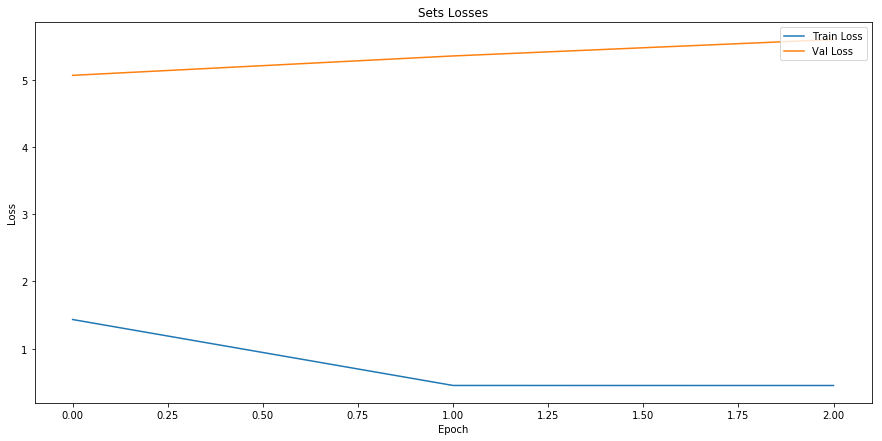

Final Train Loss: 0.4514546549289223
Val loss: 5.063108741760254


In [0]:
plot_model_losses(resume)

Se aprecia un claro overfitting entre los conjuntos de entrenamiento y validación. 

 g) Debido a lo costoso de tener una red completamente recurrente para entrenar y poder experimentar, cambie el modelo que procesa el *Encoder* por una red convolucional, reduciendo el número de capas pero aumentando las neuronas. Utilice tamaños de *kernel*  igual a 5 y funciones de activaciones relu. Se agregan capas de *BatchNormalization* debido a que en el *Decoder* contamos con redes recurrentes que tienen capa activación distinta a la usada por las convoluciones. La capa de *GlobalMaxPooling1d* es lo que permite reducir toda la información extraída a un único vector, como se realizó anteriormente con *return_sequences=False*, comente sobre la ganancia o

In [0]:
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPooling1D,GlobalAveragePooling1D,BatchNormalization
model_C = Sequential()
model_C.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model_C.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model_C.add(BatchNormalization()) #for stability
model_C.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model_C.add(BatchNormalization())
model_C.add(GlobalMaxPooling1D()) #aka to return_sequences=False
model_C.add(RepeatVector(max_out_length)) #conection
model_C.add(CuDNNGRU(256, return_sequences=True))
model_C.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model_C.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
model_C.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 38, 100)           333100    
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 38, 256)           128256    
_________________________________________________________________
batch_normalization_39 (Batc (None, 38, 256)           1024      
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 38, 256)           327936    
_________________________________________________________________
batch_normalization_40 (Batc (None, 38, 256)           1024      
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 256)               0         
_________________________________________________________________
repeat_vector_25 (RepeatVect (None, 2, 256)            0         
__________

Entrene el modelo igual a lo presentado anteriormente pero ahora por 20 *epochs* ¿Cambian los tiempos de procesamiento y la cantidad de parámetros?

In [0]:
resume = model_C.fit(X_train, Y_train, epochs=20, batch_size=256,validation_data=(X_valid, Y_valid), sample_weight = sample_weight, verbose = 0)

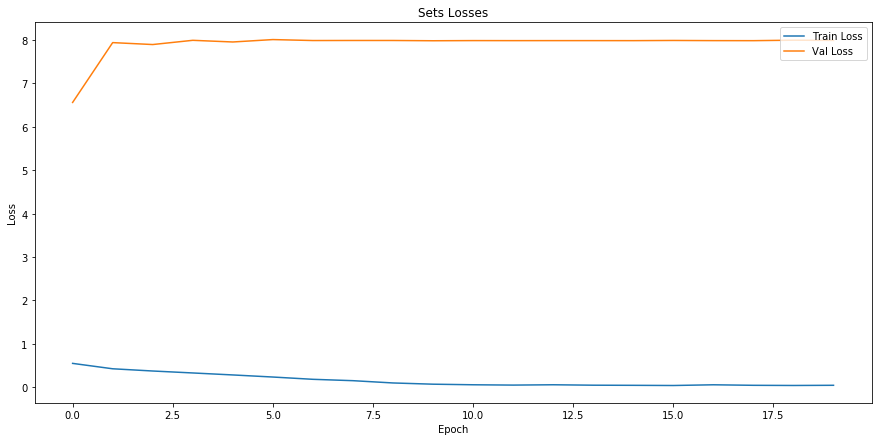

Final Train Loss: 0.04643341852480069
Val loss: 6.5617279541015625


In [0]:
plot_model_losses(resume)

 h) Visualice lo aprendido por el modelo sobre algunos datos del conjunto de entrenamiento y validación, comente lo observado.

In [0]:
def predict_words(y_indexs, data="target"):
    """ Predict until '-#end-' is seen """
    return_val = []
    for indx_word in y_indexs:
        if indx_word != 0: #start to predict
            return_val.append(np.squeeze(indx_word))
            if data == "target": #if target is predicting
                if indx_word == word2idx_t["#end"]:
                    return return_val                
    return return_val
n_s = 100
idx = np.random.choice(np.arange(Y_test.shape[0]), size=n_s, replace=False)
Y_set_pred = model.predict_classes(X_test[idx])

for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_test[n_sampled], data="source")]
    print("Texto source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_test[n_sampled,:,0], data="target")]
    print("Texto target real: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_set_pred[i], data="target")]
    print("Texto target predicho: ", ' '.join(text_sampled))

Texto source:  tom was standing just in front of a large building that was up for sale
Texto target real:  #end
Texto target predicho:  #end
Texto source:  i agreed to help him in his work
Texto target real:  #end
Texto target predicho:  #end
Texto source:  can i get a blanket
Texto target real:  #end
Texto target predicho:  #end
Texto source:  hand me that bag
Texto target real:  #end
Texto target predicho:  #end
Texto source:  the train was moving at miles per hour
Texto target real:  #end
Texto target predicho:  #end
Texto source:  you guys havent eaten yet have you
Texto target real:  #end
Texto target predicho:  #end
Texto source:  could you give me change for a dollar
Texto target real:  #end
Texto target predicho:  #end
Texto source:  she started doing her homework right after dinner
Texto target real:  #end
Texto target predicho:  #end
Texto source:  the policeman the arm
Texto target real:  #end
Texto target predicho:  #end
Texto source:  i think hes right
Texto target real:  

In [0]:
Y_set_pred_c = model_C.predict_classes(X_test[idx])

for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_test[n_sampled], data="source")]
    print("Texto source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_test[n_sampled,:,0], data="target")]
    print("Texto target real: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_set_pred_c[i], data="target")]
    print("Texto target predicho: ", ' '.join(text_sampled))

Texto source:  tom was standing just in front of a large building that was up for sale
Texto target real:  #end
Texto target predicho:  #end
Texto source:  i agreed to help him in his work
Texto target real:  #end
Texto target predicho:  #end
Texto source:  can i get a blanket
Texto target real:  #end
Texto target predicho:  #end
Texto source:  hand me that bag
Texto target real:  #end
Texto target predicho:  #end
Texto source:  the train was moving at miles per hour
Texto target real:  #end
Texto target predicho:  #end
Texto source:  you guys havent eaten yet have you
Texto target real:  #end
Texto target predicho:  #end
Texto source:  could you give me change for a dollar
Texto target real:  #end
Texto target predicho:  #end
Texto source:  she started doing her homework right after dinner
Texto target real:  #end
Texto target predicho:  #end
Texto source:  the policeman the arm
Texto target real:  #end
Texto target predicho:  #end
Texto source:  i think hes right
Texto target real:  

i) Realice algún cambio esperando que mejore el modelo entrenado, luego vuelva a visualizar lo predicho por la red *vs* lo real. *Debido a lo costoso en entrenar puede optar por realizar solo un cambio pero que sea significativo*.  Se comentan algunas opciones para utilizar y combinar:
* Cambiar  el *embedding* por alguno pre-entrenado
* Agregar regularizadores
* Asignar peso a las clases/palabras de salida
* Cambiar *Global max pooling* por *Average max pooling*
* Aumentar o reducir capas
* Aumentar o reducir neuronas/unidades 

In [0]:
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPooling1D,GlobalAveragePooling1D,BatchNormalization
model_CC = Sequential()
model_CC.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model_CC.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model_CC.add(BatchNormalization()) #for stability
model_CC.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model_CC.add(BatchNormalization())
model_CC.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model_CC.add(BatchNormalization()) #for stability
model_CC.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model_CC.add(BatchNormalization())
model_CC.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model_CC.add(BatchNormalization()) #for stability
model_CC.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model_CC.add(BatchNormalization())
model_CC.add(GlobalMaxPooling1D()) #aka to return_sequences=False
model_CC.add(RepeatVector(max_out_length)) #conection
model_CC.add(CuDNNGRU(256, return_sequences=True))
model_CC.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model_CC.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
model_CC.summary()
resume = model_CC.fit(X_train, Y_train, epochs=50, batch_size=256,validation_data=(X_valid, Y_valid), sample_weight = sample_weight, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 38, 100)           333100    
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 38, 256)           128256    
_________________________________________________________________
batch_normalization_41 (Batc (None, 38, 256)           1024      
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 38, 256)           327936    
_________________________________________________________________
batch_normalization_42 (Batc (None, 38, 256)           1024      
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 38, 256)           327936    
_________________________________________________________________
batch_normalization_43 (Batc (None, 38, 256)           1024      
__________

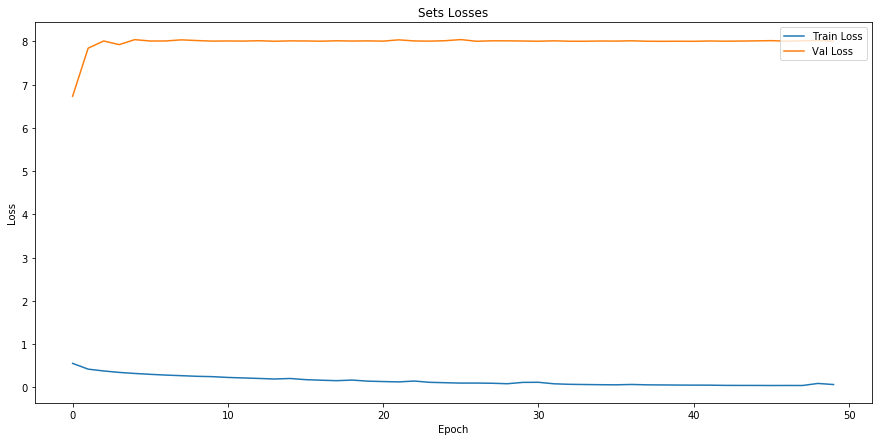

Final Train Loss: 0.06357577460071441
Val loss: 6.733124116516113


In [0]:
plot_model_losses(resume)

In [0]:
Y_set_pred_cc = model_CC.predict_classes(X_test[idx])

for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_test[n_sampled], data="source")]
    print("Texto source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_test[n_sampled,:,0], data="target")]
    print("Texto target real: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_set_pred_cc[i], data="target")]
    print("Texto target predicho: ", ' '.join(text_sampled))

Texto source:  tom was standing just in front of a large building that was up for sale
Texto target real:  #end
Texto target predicho:  #end
Texto source:  i agreed to help him in his work
Texto target real:  #end
Texto target predicho:  #end
Texto source:  can i get a blanket
Texto target real:  #end
Texto target predicho:  #end
Texto source:  hand me that bag
Texto target real:  #end
Texto target predicho:  #end
Texto source:  the train was moving at miles per hour
Texto target real:  #end
Texto target predicho:  #end
Texto source:  you guys havent eaten yet have you
Texto target real:  #end
Texto target predicho:  #end
Texto source:  could you give me change for a dollar
Texto target real:  #end
Texto target predicho:  #end
Texto source:  she started doing her homework right after dinner
Texto target real:  #end
Texto target predicho:  #end
Texto source:  the policeman the arm
Texto target real:  #end
Texto target predicho:  #end
Texto source:  i think hes right
Texto target real:  

 j) A pesar de que la tarea de medir qué tan similar es un texto a otro ya es un área de investigación propia [[6]](#refs), usted deberá utilizar alguna métrica de desempeño para ver qué tan buena es la traducción del texto *versus* el texto real entregado. Debido a que la métrica de *Exact Matching* (EM) puede ser muy drástica, mida *f1 score* por texto además de proponer alguna otra técnica de evaluación para medir sobre el conjunto de pruebas y los otros conjuntos si estima conveniente. Puede basarse en otros trabajos como *Image captioning* o *Text summary*. 
*Hint: Debido a los problemas de memoria al realizar un forward-pass, solo seleccione un subconjunto $N_{sub}$ del conjunto de pruebas para realizar ésta evaluación, se aconseja entre 1000 y 5000.*

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
m = MultiLabelBinarizer().fit([np.arange(n_words_t)]) 
def calculate_f1(true, pred):
    true = np.squeeze(true)
    pred = np.squeeze(pred)
    binarized_true = m.transform([predict_words(true)])[0] #onehot of words appear
    binarized_pred = m.transform([predict_words(pred)])[0] #onehot of words appear
    return f1_score(binarized_true, binarized_pred, average='binary') #only on appearing words

In [0]:
Y_set_pred = model.predict_classes(X_test[idx])
Y_set_pred_c = model_C.predict_classes(X_test[idx])
Y_set_pred_cc = model_CC.predict_classes(X_test[idx])

In [0]:
f1_final = np.mean([calculate_f1(true_words,pred_words) for true_words,pred_words in zip(Y_test,Y_set_pred)])
f1_final_c = np.mean([calculate_f1(true_words,pred_words) for true_words,pred_words in zip(Y_test,Y_set_pred_c)])
f1_final_cc = np.mean([calculate_f1(true_words,pred_words) for true_words,pred_words in zip(Y_test,Y_set_pred_cc)])

In [0]:
print("F1 normal : %d"%f1_final)
print("F1 normal : %d"%f1_final_c)
print("F1 normal : %d"%f1_final_cc)

F1 normal : 0
F1 normal : 0
F1 normal : 0


 La función de *f1 score* en este extracto se calcula en base al *precision* y *recall* de que aparezca cada una de las palabras predichas dentro de las palabras reales (como si cada palabra fuera una clase de "aparece" o no), **sin importar el orden ni la ocurrencia**.

k) En ves de volver a variar el modelo de *Encoder*, dejaremos una representación manual explícita (*no entrenable*) a través de extraer características manuales de los textos *source*, como por ejemplo representaciones *term frequency* (TF) o TF-IDF, proporcionadas a través de __[sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text)__. Luego, con esto generado, defina y entrene el modelo *Decoder* neuronal como el presentado en las preguntas anteriores, ésto es comenzar desde la capa *RepeatVector* hasta llegar a la clasificación sobre el texto *target*. Compare el desempeño con lo presentado en (j) y lo visualizado en (h).

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
def dummy_fun(doc):
    return doc
tf_idf = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,preprocessor=dummy_fun,
                         token_pattern=None,use_idf= True, smooth_idf=True, norm='l2')   
X_train_tfidf = tf_idf.fit_transform(dataX_train).astype('float32').todense()
X_valid_tfidf = tf_idf.fit_transform(dataX_valid).astype('float32').todense()
X_test_tfidf = tf_idf.fit_transform(dataX_test).astype('float32').todense()

In [0]:
X_train_tfidf.shape, X_valid_tfidf.shape, X_test_tfidf.shape

((25093, 3330), (10000, 2820), (10000, 2835))

In [0]:
from keras.layers import InputLayer
model_tf = Sequential()
model_tf.add(InputLayer(input_shape=(X_train_tfidf.shape[1],)))
model_tf.add(RepeatVector(max_out_length)) #conection
model_tf.add(CuDNNGRU(512, return_sequences=True))
model_tf.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model_tf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
model_tf.summary()
resume = model_tf.fit(X_train_tfidf, Y_train, epochs=20, batch_size=256,validation_data=(X_valid_tfidf, Y_valid), sample_weight = sample_weight, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_33 (RepeatVect (None, 2, 3330)           0         
_________________________________________________________________
cu_dnngru_59 (CuDNNGRU)      (None, 2, 512)            5904384   
_________________________________________________________________
time_distributed_33 (TimeDis (None, 2, 351)            180063    
Total params: 6,084,447
Trainable params: 6,084,447
Non-trainable params: 0
_________________________________________________________________


ValueError: ignored

In [0]:
from keras.layers import Bidirectional

model_B = Sequential()
model_B.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length, trainable=True))
gate_layer1 = CuDNNGRU(128, return_sequences=False)
model_B.add(Bidirectional(gate_layer1, merge_mode='concat'))
model_B.add(RepeatVector(max_out_length)) #conection
gate_layer2 = CuDNNGRU(128, return_sequences=True)
model_B.add(Bidirectional(gate_layer2, merge_mode='concat'))
model_B.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model_B.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
model_B.summary()
resume = model_B.fit(X_train_tfidf, Y_train, epochs=20, batch_size=256,validation_data=(X_train_tfidf, Y_valid), sample_weight = sample_weight, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 38, 100)           333100    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               176640    
_________________________________________________________________
repeat_vector_32 (RepeatVect (None, 2, 256)            0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 2, 256)            296448    
_________________________________________________________________
time_distributed_32 (TimeDis (None, 2, 351)            90207     
Total params: 896,395
Trainable params: 896,395
Non-trainable params: 0
_________________________________________________________________


ValueError: ignored

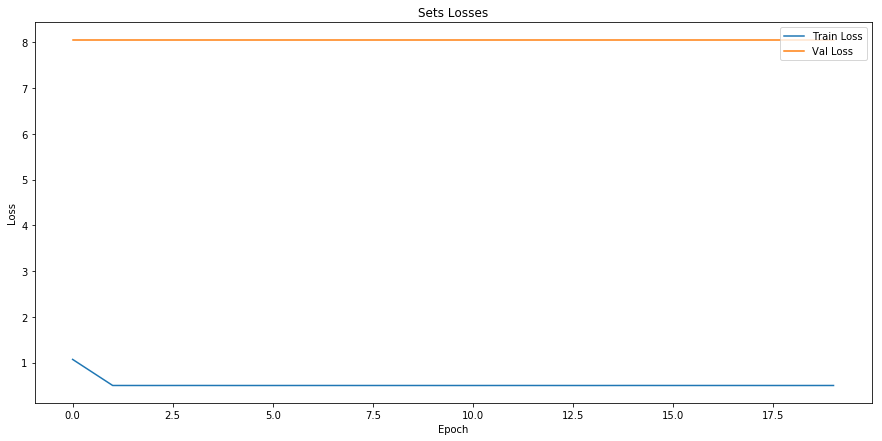

Final Train Loss: 0.4994295698911695
Val loss: 8.059066772460938


In [0]:
plot_model_losses(resume)

<a id="refs"></a>
## Referencias
[1] https://es.wikipedia.org/wiki/Ley_de_Zipf    
[2] Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). *Efficient estimation of word representations in vector space*. arXiv preprint arXiv:1301.3781.    
[3] Cho, K., Van Merriënboer, B., Bahdanau, D., & Bengio, Y. (2014). *On the properties of neural machine translation: Encoder-decoder approaches*. arXiv preprint arXiv:1409.1259.  
[4] Pal, N. R., & Pal, S. K. (1993). *A review on image segmentation techniques*. Pattern recognition, 26(9), 1277-1294.  
[5] Badrinarayanan, V., Kendall, A., & Cipolla, R. (2017). *Segnet: A deep convolutional encoder-decoder architecture for image segmentation*. IEEE transactions on pattern analysis and machine intelligence, 39(12), 2481-2495.  
[6] Papineni, K., Roukos, S., Ward, T., & Zhu, W. J. (2002, July). *BLEU: a method for automatic evaluation of machine translation*. In Proceedings of the 40th annual meeting on association for computational linguistics (pp. 311-318). Association for Computational Linguistics.  
[7] Kingma, D. P., & Welling, M. (2013). *Auto-encoding variational bayes*. arXiv preprint arXiv:1312.6114.  
[8] https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence     
[9] Dumoulin, V., & Visin, F. (2016). *A guide to convolution arithmetic for deep learning*. arXiv preprint arXiv:1603.07285.  also: https://github.com/vdumoulin/conv_arithmetic  
[10] Jang, E., Gu, S., & Poole, B. (2016). *Categorical reparameterization with gumbel-softmax*. arXiv preprint arXiv:1611.01144.  
[11] https://en.wikipedia.org/wiki/Cluster_analysis  